CS530 Group Project 


Hesam Sadri, Celeste Manughian-Peter, Hanna Lu


May 23, 2020



# Project Description

## Motivation   

Netflix held the Netflix Prize open competition for the best algorithm to predict user ratings for films. The grand prize was $1,000,000 and was won by BellKor's Pragmatic Chaos team. This is the dataset that was used in that competition.  

We aimed to build a movie recommendation mechanism with movie ratings from Netflix users. The dataset comes directly from Netflix, and is available on Kaggle. 

## Introduction to the Dataset 

The data consists of four text data files, each file containing over 20 million rows (over 4K movies and 400K customers). All together, over 17K movies and 500K+ customers! 
From Kaggle.com we obtained 17,770 movies, and 480,189 customers. Each customer rates multiple movies. There were 5 datasets: 

* Movie Title dataset (17,770 rows, 3 features: Movie ID, Year of Release, Title)
* 4 Ratings datasets (over 100 million rows with 3 features: Customer ID, Rating, Date)

We used subsets of the data due to memory limitations:
* 400 movie subset (over 2 million rows)
* 700 movie subset (over 3.5  million rows)
* 1000 movie subset (over 5 million rows)


### Training Dataset Description 

The file "training_set.tar" is a tar of a directory containing 17770 files, one
per movie. The first line of each file contains the movie ID, followed by a
colon. Each subsequent line in the file corresponds to a rating from a customer
and its date in the following format:

CustomerID, Rating, Date

    MovieIDs range from 1 to 17770 sequentially.
    CustomerIDs range from 1 to 2649429, with gaps. There are 480189 users.
    Ratings are on a five star (integral) scale from 1 to 5.
    Dates have the format YYYY-MM-DD.

### Movies file description 

Movie information in "movie_titles.txt" is in the following format:

MovieID, YearOfRelease, Title

    MovieID do not correspond to actual Netflix movie ids or IMDB movie ids.
    YearOfRelease can range from 1890 to 2005 and may correspond to the release of
    corresponding DVD, not necessarily its theaterical release.
    Title is the Netflix movie title and may not correspond to
    titles used on other sites. Titles are in English.
    QUALIFYING AND PREDICTION DATASET FILE DESCRIPTION:

The qualifying dataset for the Netflix Prize is contained in the text file "qualifying.txt". It consists of lines indicating a movie id, followed by a colon, and then customer ids and rating dates, one per line for that movie id. The movie and customer ids are contained in the training set. Of course the
ratings are withheld. There are no empty lines in the file. It is presented in the following format:

    MovieID1:
    CustomerID11,Date11
    CustomerID12,Date12
    
    …
    
    MovieID2:
    CustomerID21,Date21
    CustomerID22,Date22

For the Netflix Prize, the algorithm must predict the all ratings the customers gave the movies in the qualifying dataset based on the information in the training dataset.
tc.

The data-set and other information about the problem can be seen here: https://www.kaggle.com/netflix-inc/netflix-prize-data

## The Problem 

Given observations (ratings) of a user’s past behavior, the aim is to predict which other things that same user will like (movies) using serveral algorithms to create a recommender system. Most internet products we use today are powered by recommender systems. Youtube, Netflix, Amazon, Pinterest rely on recommender systems to make personalized recommendations to their users. Recommender systems are well-studied and proven to provide tremendous values to internet businesses and their consumers. They can be loosely broken down into three categories: content based systems, collaborative filtering systems, and hybrid systems (which use a combination of the other two).

<img src="./files/rec_system">

# Project Algorithm

## Data Processing and Visualization

### Loading the data

In [45]:
import random
import pandas as pd
import numpy as np
import math
import re
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_style("darkgrid")

from scipy.sparse import csr_matrix # pivot ratings into movie features
from scipy import sparse

from sklearn.metrics.pairwise import cosine_similarity
import sklearn.preprocessing as pp
from sklearn.metrics.pairwise import cosine_similarity


from surprise import Reader, Dataset,SlopeOne, SVD ,accuracy,Trainset,KNNWithMeans,KNNBasic,BaselineOnly,CoClustering,SVDpp,NMF,KNNBaseline
from surprise.model_selection import train_test_split,cross_validate,GridSearchCV
from surprise import accuracy
from surprise import Reader, Dataset, SVD # pip install scikit-surprise

### Pre-processing the data

The data set from Kaggle is clean with no missing values and no outliers, so not much preprocessing needed to be done. 

Reformatting the ratings data was necessary. Ratings are stored in 4 datasets, which needed to be combined. The Movie ID in the ratings dataset were mixed in the rows. We extracted the Movie ID and assigned them to rows in the ratings dataset using a pivot operation. 

Reformatting the dataframe into a sparse matrix was also necessary for the manual implementation of KNN. 

In [37]:
# Preprocess datasets here
movies = pd.read_csv('movie_titles.csv', 
                     header = None, 
                     usecols = [0,1,2], 
                     names = ['MovieID', 'YearOfRelease', 'Title'],
                     encoding='latin1')
# movies.head()
df = pd.read_csv('combined_data_1.txt', 
                  names = ['Cust_Id', 'Rating'], 
                  usecols = [0,1])
nan = pd.DataFrame(pd.isnull(df['Rating']))
movie_id = df[nan['Rating'] == True]['Cust_Id']
# # df_100 = df.iloc[:352871,]
# df_100 = df.iloc[:5010438] # 1000
# # m_id = movie_id.iloc[:101,] 
# m_id = movie_id.iloc[:1000,] # 1000

# Takethe first 400 movies
df_400 = df.iloc[:2112852,]
m_id = movie_id.iloc[:401,]

# Use the index of the movies to generate Movie IDs corresponding to the rows (cutomer IDs)
Movie_ID = []
# for i in range(1,101):
# for i in range(1,1000):
for i in range(1,401):
    Movie_ID.append((m_id.index[i]-m_id.index[i-1])*[i])
MovieID = sum(Movie_ID, [])
# Verify that they are the same length
# print(len(MovieID),df_100.shape[0])
# Assign the Movie IDs to the rows
df_400['MovieID'] = MovieID
# df_100['MovieID'] = MovieID
# Delete the rows with the original Movie IDs
# df_100_noNA = df_100.dropna()
df_400_1 = df_400.dropna()

/home/celeste/.local/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [12]:
df_400_1.tail()

Cust_Id  Rating  MovieID
2112847   823628     5.0      400
2112848   324510     2.0      400
2112849  2039976     5.0      400
2112850   491907     4.0      400
2112851  2560280     2.0      400

Check data attributes...

In [39]:
print(df_400_1.isnull().sum())
print(df_400_1.shape)
display(df_400_1.head())

Cust_Id    0
Rating     0
MovieID    0
dtype: int64
(2112452, 3)


Cust_Id  Rating  MovieID
1  1488844     3.0        1
2   822109     5.0        1
3   885013     4.0        1
4    30878     4.0        1
5   823519     3.0        1

In [89]:
# Free up some memory
# del nan
# del df_100
# del df_400

### Exploratory Data Analysis

To check for outliers and gauge the overall characteristics of our data subsets, we developed a few plots. The first plot shows the distribution of movie ratings in one of the data subsets using 400 movies. This distribution is mirrored in larger subsets of dataset.


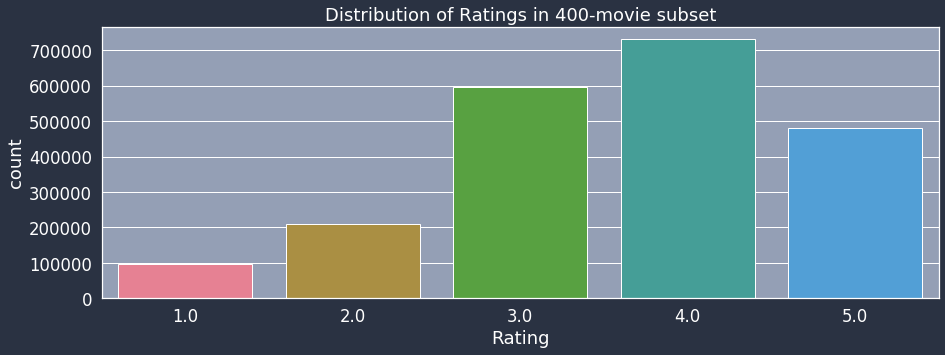

In [9]:
plt.figure(figsize=(15,5))
sns.set(rc={'text.color':"white", 
            'axes.labelcolor': 'white', 
            'xtick.color': 'white', 
            'ytick.color': 'white', 
            'axes.facecolor': '#949fb5',
            'figure.facecolor': '#2a3242'}, 
        font_scale=1.5, palette='husl')
sns.countplot(df_400_noNA.Rating)
_ = plt.title("Distribution of Ratings in 400-movie subset")

The next plot shows the distribution of total ratings per movie vs average rating for movie. We expect the majority of movies to have a few thousand ratings and the rest are much less known with little or no user-interactions. We can see that each movie have between e^4-e^12 ratings from customers (54 - 164,000) and most movies have an average rating around 3.6 with a standard deviation 1.1.

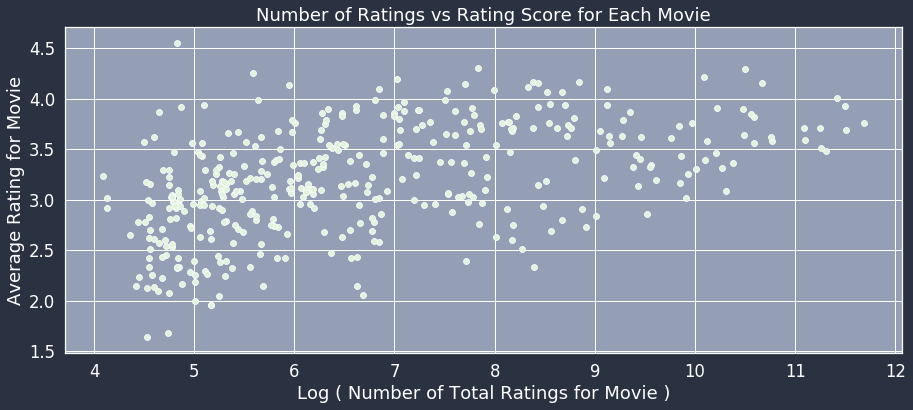

In [10]:
import seaborn as sns
sns.set(rc={'text.color':"white", 
            'axes.labelcolor': 'white', 
            'xtick.color': 'white', 
            'ytick.color': 'white', 
            'axes.facecolor': '#949fb5',
            'figure.facecolor': '#2a3242'}, 
        font_scale=1.5, palette='Greens')
count_rating = df_400_noNA.groupby(['MovieID'])['Rating'].agg(['count','mean'])
plt.figure(figsize=(15,6))
sns.scatterplot(np.log(count_rating['count']), count_rating['mean'])
plt.xlabel('Log ( Number of Total Ratings for Movie )')
plt.ylabel('Average Rating for Movie')
plt.title('Number of Ratings vs Rating Score for Each Movie')
plt.show()

## Model Construction

For this project, we went through a few different algorithms to analyze the effectiveness of each: 
* SVD (Singular Value Decomposition)
* SVD++ (SVD Plus Plus)
* NMF (Non-negative Matrix Factorization)
* BaselineOnly
* SlopeOne
* KNNBasic
* KNNBaseline
* KNNWithMeans

We ran these with several varying size subsets, 400, 700 and 1000 movies. We only include the 400-movie subset in this notebook and a link to the other notebooks with more detailed runs, since those take a long time to run. 

### Collaborative filtering 

Each of these are collaborative filtering techniques. We chose collaborative filtering because it is one step beyond what we learned in class, and can be implemented in combinations with algorithms we learned to create a recommendation system. Collaborative filtering is based on the assumption that people who agreed in the past will agree in the future, and that they will like similar kinds of items as they liked in the past. When we want to recommend something to a user, the most logical thing to do is to find people with similar interests, analyze their behavior, and recommend our user the same items.(user based) or we can look at the items similar to ones which the user bought earlier, and recommend products which are like them.(item based). In both cases this recommendation engine has two steps: 

1. Find out how many users/items in the database are similar to the given user/item.
2. Assess other users/items to predict what grade you would give the user of this product, given the total weight of the users/items that are more similar to this one

This kind of recommendation system can be implemented with each of these algorithms. For our model construction, we mostly used the scikit surprise package, with the exception of the handwritten KNN collaborative filtering algorithm implementation. Surprise stands for Simple Python RecommendatIon Systems Engine. We also used gridsearch to tune all of the algorithms hyperparameters (3 data subset sizes * 9 algorithms). 

In the end, we eneded up fitting 81 models (3 sizes * 3 slices * 9 algorithms), and RMSE was used to evaluate the models. 


#### SVD 

SVD stands for singular value decomoposition. This is a matrix factorization algorithm, where the main assumption is that there exists a pretty low dimensional latent space of features in which we can represent both users and items. The interaction between a user and an item can be obtained by computing the dot product of corresponding dense vectors in that space. We don’t want to give explicitly these features to our model, so this lets the system discover these useful features by itself and make its own representations of both users and items.

As they are learned and not given, extracted features taken individually have a mathematical meaning but no intuitive interpretation (and, so, are difficult, if not impossible, to understand as human). However, it is not unusual to end up having structures that are extremely close to an intuitive decomposition that a human interpret. The consequence of factorisation is that users that are similar in terms of preferences and characteristics have close representations in the latent space. 

#### SVD++

SVD++ is an improvement to the SVD algorithm, which had the best performance in the Netflix competition. Modern day recommender systems should exploit all available interactions: oth explicit (e.g. numerical ratings) and implicit (e.g. likes, purchases, skipped, bookmarked). To this end, SVD++ was designed to take into account implicit interactions as well.

In our case, an implicit rating describes the fact that user u rated an item i, regardless of the rating value.

#### NMF 

NMF ia another collaborative filtering algorithm based on Non-negative Matrix Factorization.

This algorithm is very similar to SVD. We use the surprise package to run their implementation of it with our data. SVD results are more deterministic compared to that of NMF. SVD is a more 'insightful' factorization technique. NMF gives only U and V matrices, but SVD gives a Sigma matrix also along with these two. Sigma gives us insights into the amount of information each eigen vector holds. 

 
#### Slope One

Slope One is another collaborative filtering algorithm that is available in the surprise package. Slope One is actually a group of algorithms used for collaborative filtering. It was published in a 2005 paper by Daniel Lemire and Anna Maclachlan. It's the simplest form of non-trivial item-based collaborative filtering based on ratings. This algorithm's simplicity makes it very easy to implement efficiently while it's accuracy is often on par with more complicated and computationally-expensive algorithms. They have also been used as building blocks to improve other algorithms. 

It uses a simple form of linear regression to predict ratings. 


#### CoClustering

This is another collaborative filtering algorithm in the surprise package. With this algorithm, users and items are assigned some clusters Cu, Ci, and some co-clusters C_ui. This algorithm is beneficial because it is less computationally expensive than SVD. With this algorithm, it is possible to obtain an accuracy comparable to that of the correlation and matrix factorization based approaches at a much lower computational cost.


#### KNN

For a recommendation system, KNN can be used with collaborative filtering. This works by computing the similarity between all users with a specific distance metric. In our case, we used the cosine similarity to compute the user similarity matrix. With this matrix, an equation, shown in our implementaiton below, can be used to compute the estimated rating for movie i given the K nearest users to a user, along with their ratings. 

### GridSearch

We use gridsearch on a subset of the data to find the optimal hyperparameters, and run the algorithm(s) with those hyperparameters on bigger data sets, since gridsearch was too memory intensive to run on those bigger data sets. 

### KNN with Collaborative Filtering By Hand

Initially we tried KNN with collaborative filtering by hand, in hopes to optimize the memory usage with a sparse matrix. Then we moved on to use the KNNBaseline algorithm, which is the same as the by hand implementation, since this turns out to be faster. 

In [45]:
df_100_noNA.Rating = df_100_noNA.Rating.astype('int32')
df_100_noNA.Cust_Id = df_100_noNA.Cust_Id.astype('int32')
df_100_noNA.reset_index(inplace=True, drop=True)

fourth = 125235
df_movie_features = df_100_noNA[:fourth].pivot(
                index='MovieID',
                columns='Cust_Id',
                values='Rating').fillna(0)
df_movie_features.index = df_movie_features.index.map(movies.Title) # Map the movie ID to movie Title 

df_fts = df_movie_features.transpose() 
df_fts = df_fts[:12523]
df_sparse = sparse.csr_matrix(df_fts.transpose())

display(df_fts.head())

MovieID  Isle of Man TT 2004 Review  Character  Paula Abdul's Get Up & Dance  \
Cust_Id                                                                        
7                               0.0        0.0                           0.0   
42                              0.0        0.0                           0.0   
59                              0.0        0.0                           0.0   
134                             0.0        0.0                           0.0   
199                             0.0        0.0                           0.0   

MovieID  The Rise and Fall of ECW  Sick  8 Man  What the #$*! Do We Know!?  \
Cust_Id                                                                      
7                             0.0   0.0    0.0                         0.0   
42                            0.0   0.0    0.0                         0.0   
59                            0.0   0.0    0.0                         0.0   
134                           0.0   0.0    0.0                         0.0   
199                           0.0   0.0    0.0                         0.0   

MovieID  Class of Nuke 'Em High 2  Fighter  Full Frame: Documentary Shorts  \
Cust_Id                                                                      
7                             5.0      0.0                             0.0   
42                            0.0      0.0                             0.0   
59                            0.0      0.0                             0.0   
134                           0.0      0.0                             0.0   
199                           0.0      0.0                             0.0   

MovieID  ...  Chump Change  \
Cust_Id  ...                 
7        ...           0.0   
42       ...           0.0   
59       ...           0.0   
134      ...           0.0   
199      ...           0.0   

MovieID  Clifford: Clifford Saves the Day! / Clifford's Fluffiest Friend Cleo  \
Cust_Id                                                                         
7                                                      0.0                      
42                                                     0.0                      
59                                                     0.0                      
134                                                    0.0                      
199                                                    0.0                      

MovieID  My Bloody Valentine  Inspector Morse 31: Death Is Now My Neighbour  \
Cust_Id                                                                       
7                        0.0                                            0.0   
42                       0.0                                            0.0   
59                       0.0                                            0.0   
134                      0.0                                            0.0   
199                      0.0                                            0.0   

MovieID  Never Die Alone  Sesame Street: Elmo's World: The Street We Live On  \
Cust_Id                                                                        
7                    0.0                                                0.0    
42                   0.0                                                0.0    
59                   0.0                                                0.0    
134                  0.0                                                0.0    
199                  0.0                                                0.0    

MovieID  Lilo and Stitch  Boycott  Something's Gotta Give  \
Cust_Id                                                     
7                    0.0      4.0                     0.0   
42                   0.0      0.0                     0.0   
59                   0.0      0.0                     0.0   
134                  0.0      5.0                     0.0   
199                  0.0      0.0                     0.0   

MovieID  Classic Albums

In [ ]:
# # Free up some memory for the cosine similarity computation 
# # del mat_movie_features
# del df_100
# del movie_id
# del df
# del movies
# del df_100_noNA

In [46]:
def cosine_similarities(mat):
    col_normed_mat = pp.normalize(mat.tocsc(), axis=0)  # scipy.sparse.csc_matrix
    return col_normed_mat.T * col_normed_mat

customer_similarities = cosine_similarities(df_sparse)
customer_similarities= customer_similarities.toarray()

In [47]:
user_similarity_matrix = pd.DataFrame(customer_similarities)
# cs_df.columns = df_fts.index.values  # Customer IDs 12523
user_similarity_matrix.columns = df_fts[:12523].index.values  # Customer IDs 
user_similarity_matrix.index = user_similarity_matrix.columns
display(user_similarity_matrix)
# set the column and index to customer ID
# Get the top K customer scores for each row 
# Rank function

# Free up memory
del customer_similarities

7         42        59        134       199       201       261     \
7       1.000000  0.000000  0.000000  0.624695  0.000000  0.624695  0.000000   
42      0.000000  1.000000  1.000000  0.000000  1.000000  0.000000  1.000000   
59      0.000000  1.000000  1.000000  0.000000  1.000000  0.000000  1.000000   
134     0.624695  0.000000  0.000000  1.000000  0.000000  1.000000  0.000000   
199     0.000000  1.000000  1.000000  0.000000  1.000000  0.000000  1.000000   
...          ...       ...       ...       ...       ...       ...       ...   
336842  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
336847  0.487805  0.000000  0.000000  0.780869  0.000000  0.780869  0.000000   
336882  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
336895  0.624695  0.000000  0.000000  1.000000  0.000000  1.000000  0.000000   
336940  0.441726  0.707107  0.707107  0.707107  0.707107  0.707107  0.707107   

          265       307       383     ...    336784    336789    336807  \
7       0.624695  0.780869  0.624695  ...  0.624695  0.374817  0.624695   
42      0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
59      0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
134     1.000000  0.000000  1.000000  ...  1.000000  0.600000  1.000000   
199     0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
...          ...       ...       ...  ...       ...       ...       ...   
336842  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
336847  0.780869  0.000000  0.780869  ...  0.780869  0.468521  0.780869   
336882  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
336895  1.000000  0.000000  1.000000  ...  1.000000  0.600000  1.000000   
336940  0.707107  0.000000  0.707107  ...  0.707107  0.424264  0.707107   

          336821  336829  336842    336847  336882    336895    336940  
7       0.000000     0.0     0.0  0.487805     0.0  0.624695  0.441726  
42      1.000000     0.0     0.0  0.000000     0.0  0.000000  0.707107  
59      1.000000     0.0     0.0  0.000000     0.0  0.000000  0.707107  
134     0.000000     0.0     0.0  0.780869     0.0  1.000000  0.707107  
199     1.000000     0.0     0.0  0.000000     0.0  0.000000  0.707107  
...          ...     ...     ...       ...     ...       ...       ...  
336842  0.000000     0.0     1.0  0.000000     0.0  0.000000  0.000000  
336847  0.000000     0.0     0.0  1.000000     0.0  0.780869  0.552158  
336882  0.000000     0.0     0.0  0.000000     1.0  0.000000  0.000000  
336895  0.000000     0.0     0.0  0.780869     0.0  1.000000  0.707107  
336940  0.707107     0.0     0.0  0.552158     0.0  0.707107  1.000000  

[12523 rows x 12523 columns]

#### Predict Score Calculation
##### Implement custom ranking function

KNN nearest neighbor selection After the calculation of similarity between users, then  the  algorithm  selects  a  number  of  users  the  highest  similarity as the U’s neighbor, denoted as u'. set a fixed value K  for  the  neighbor  selection,  select  only  the  most  K  high  similarity as neighbors regardless of the value of the neighbor similarity of users. As shown in figure 4. Fig.4. formula of K nearest neighbors when k=7 3.3Predict score calculation After  determining  the  user's  neighbors,  the  score  can  be  predicted according to the score of the neighbor to the item
<img src="files/ranking_function.png">
The above equation is used to get the ranking r for user u on movie i. 
It states that the ranking r for user u on movie i is equal to the average ranking from the user u (?) plus the SUM from other users in the top similar users of the similarity of those two users (proportionality) times the ranking user u' gave movie i - the average ranking user u' gave to its movies. 

In [48]:
def rank_user_movie(user_row, movie_id, df):
    user_similarities_top_k = user_row.nlargest(K)  # Most similar customers to customer in user_row 
    nearest_neighbors_cust_ID = user_similarities_top_k.index.values

    r_u = df.loc[user_id]  #  ranking from the user u - user user_id's row from df across all movies
    r_u_bar = np.mean(r_u.where(r_u>0)) # average nonzero rankings in all user's rankings, r_u

    k = 1/np.sum(user_similarities_top_k)
    # For each most nearest user u', zum the similarity between that user and our user u, times the 
    # rank for nearest user u' for that specific movie - the average ranking for all movies for nearest user u'
    sum3=[]
    for u_prime, sim_u_uprime in zip(nearest_neighbors_cust_ID, user_similarities_top_k):
        r_u_prime_i=df.loc[u_prime][movie_id]
        r_u_prime = df.loc[u_prime]
        r_u_prime_bar= np.mean(r_u_prime.where(r_u_prime>0))
        sum3.append(sim_u_uprime*(r_u_prime_i - r_u_prime_bar))

    r_u_i = r_u_bar + k*np.sum(sum3)
    return r_u_i 

In [49]:
K=20
movie_id = "Lilo and Stitch"
user_id = 7
df = df_fts
user_row = user_similarity_matrix.loc[user_id]  # Customer user_id's similarities to all other customers 

rank_user_movie(user_row=user_row, movie_id="Lilo and Stitch",df=df)

0.24990850310544754

In [ ]:
# # Predict the rating for user 822109 on movie 1: 
# uid = str(822109) 
# iid = str(1)
# TODO

In [ ]:
# TODO: RMSE 

In [93]:
# Free up space
del df_fts
del df_fts2
del df_sparse

Using the by-hand KNN Collaborative filtering implementation with datasets larger than the one used here resulted in out-of-memory errors.

### SVD, NMF, SlopeOne, CoClustering, SVD++, and KNN

In addition to doing the KNN by hand, we moved on to use the surprise package to implement KNN and our other algorithms. 


We will define a function to make predictions and obtain the RMSE for each model:

In [43]:
def fit_predict(algo, train, test):
    model = algo.fit(train)
    prediction = model.test(test)
    return(accuracy.rmse(prediction))

Next, we loop through all the subsets of data and calculate the RMSE for each of the mentioned algorithms. Here we use the optimal hyperparameters obtained through using GridSearch (shown in the <font color="grey">"Netflix Movie Recommender GridSearch.ipynb notebook"</font>). This was very time-consuming to run both gridsearch and for larger subsets; for this report we keep it to the minimal 400-movie subset and refernece the work done to run the larger subsets.  

In [46]:
reader = Reader(rating_scale=(1, 5))
df_all = [df_400_1] #, df_400_2, df_400_3]
rmse = []

for data in df_all:
    d = Dataset.load_from_df(data[['Cust_Id', 'MovieID', 'Rating']], reader)
    train, test = train_test_split(d, test_size = 0.3)
    
    # SVD:
    print("SVD:")
    svd = SVD(n_factors = 20, lr_all = 0.005, reg_all = 0.01)
    rmse.append(fit_predict(svd, train, test))
    
    # NMF:
    print("NMF:")
    nmf = NMF(n_factors = 20, n_epochs = 20, biased = True)
    rmse.append(fit_predict(nmf, train, test))
    
    # SlopeOne:
    print("SlopeOne:")
    slope = SlopeOne()
    rmse.append(fit_predict(slope, train, test))
    
    # CoClustering:
    print("CoClustering:")
    cc = CoClustering(n_cltr_u = 2, n_cltr_i = 2)
    rmse.append(fit_predict(cc, train, test))
    
    # BaselineOnly
    print("BaselineOnly:")
    bsl_options = {'method': 'sgd','learning_rate': .00005}
    bsl = BaselineOnly(bsl_options = bsl_options)
    rmse.append(fit_predict(bsl, train, test))
    
    # SVD++
    print("SVD++:")
    svdpp = SVDpp(n_factors = 50, lr_all = 0.005, reg_all = 0.02)
    rmse.append(fit_predict(svdpp, train, test))

    # KNNBasic
    print("KNNBasic:")
    sim_options = {'name': 'MSD', 'user_based': False}
    knn_basic = KNNBasic(k=20, sim_options = sim_options, min_k = 5)
    rmse.append(fit_predict(knn_basic, train, test))
    
    # KNNWithMeans
    print("KNNWithMeans:")
    sim_options = {'name': 'MSD', 'user_based': False, 'shrinkage': 10}
    knn = KNNWithMeans(k=20, sim_options = sim_options, min_k = 8)
    rmse.append(fit_predict(knn, train, test))
    
    # KNNBaseline
    print("KNNBaseline")
    sim_options = {'name': 'MSD', 'user_based': False, 'shrinkage': 10}
    knn_bsl = KNNBaseline(k=20, sim_options = sim_options, min_k = 8)
    rmse.append(fit_predict(knn_bsl, train, test))

SVD:
RMSE: 1.0148
NMF:
RMSE: 1.0202
SlopeOne
RMSE: 1.0349
CoClustering:
RMSE: 1.0664
BaselineOnly:
Estimating biases using sgd...
RMSE: 1.0276
SVD++:
RMSE: 0.9780
KNNBasic:
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0426
KNNWithMeans:
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9947
KNNBaseline
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9802


The results for the algorithms shown above are promising. We see that SVD++ is one of the highest performing algorithms. To further analyze the algorithms, we created 3 subsets for each size of 400, 700, and 1000 movies. For example, for the 400 subset size, we took the first 400 movies, then the second 400, and third 400 movies for slice 1, 2, and 3 respectively. 

<img src="./files/rmse_sample_slices.png">
<font color="grey">Values calculated in "Netflix Movie Recommendation Slices.ipynb"</font>

We can see that the RMSE is going downward over time for almost all of the algorithms. This is expected: as we obtain more data, the predictions should be more accurate. 

Since the memory load on our computers was too large to handle, we can make a regression line to fit to the RMSE data to get an idea of what our accuracy wouldve been with a larger data set. This assumes it would be following the same trend as our RMSE has shown for the three 400, 700, 1000-movie subsets. 

<b> Regression for RMSE</b>

In [67]:
from sklearn.linear_model import LinearRegression
# Create regression line for best performing algorithms
# SVDpp
lr = LinearRegression()
x = np.array([400, 700, 1000]).reshape((-1, 1))
y = np.array([.97, .96, .94]).reshape((-1, 1))
lr.fit(x, y)
#KNN
knnlr = LinearRegression()
y = np.array([.97, .96, .94]).reshape((-1, 1))
knnlr.fit(x, y)

# Predict other accuracies
bigger_data_sizes = np.array([5000, 1000, 17700]).reshape((-1,1))
yp = lr.predict(bigger_data_sizes)
# Plot
plt.figure(figsize=(10,4))
_ = plt.plot(bigger_data_sizes, yp)
plt.scatter(bigger_data_sizes, yp)
_ = plt.title("Predicted Accuracy for Larger Data Subsets")
_ = plt.xlabel("Sample Size")
_ = plt.ylabel("RMSE")

We can estimate that, given the current trend of our RMSE on smaller subsets, that the full data set would have an accuracy for the algorithms as shown in the above plot. In this scenario, SVD++ and KNNBaseline still have the best performance as a recommender system.  

### Testing the models: Predictions and Recommendations

For our algorithms, we saw that the larger the sample size, the smaller the RMSE. We expect we could've obtained the RMSE that the winning Netflix prize team obtained if we had more RAM to run our algorithms with. 
Our best-performing models were SVD++ and KNNBaseline, with an RMSE of 0.9207.

TODO: Why are these two the best?

(2112452, 3)

In [94]:
# Build the model with the best algorithm (SVD++)
d = Dataset.load_from_df(df_400_1[['Cust_Id', 'MovieID', 'Rating']], reader)
train, test = train_test_split(d, test_size = 0.3)
svdpp = SVDpp(n_factors = 50, lr_all = 0.005, reg_all = 0.02)
svdpp = svdpp.fit(train)

In [95]:
def pred_movie_merge(prediction):
    global movies
    Cust_Id, MovieID, Rating, Predicted_Rating = [], [], [], []
    
    # Convert the predictions to a dataframe:
    for i in range(len(prediction)):
        Cust_Id.append(prediction[i][0])
        MovieID.append(prediction[i][1])
        Predicted_Rating.append(prediction[i][3])
    df = pd.DataFrame({'Cust_Id':Cust_Id,'MovieID':MovieID,'Predicted_Rating':Predicted_Rating}) 
    
    # Merge the predictions and movies datasets to get the Movie Title and Year of Release columns:
    df['MovieID'] = df['MovieID'].astype(str)
    movies['MovieID'] = movies['MovieID'].astype(str)
    pred_movie = pd.merge(df, movies, how = 'left', on = 'MovieID')
    
    return(pred_movie)

In [96]:
def recommend(dataset, model, customerID, top=5):
    m_ids = dataset['MovieID'].unique() # Find unique movie IDs
    rated = dataset.loc[dataset['Cust_Id']==str(customerID),'MovieID'] # Find the movies the customer rated
    m_to_pred = np.setdiff1d(m_ids, rated) # Remove the movies the customer rated
    test_set = [[str(customerID), m, 4.] for m in m_to_pred] # Make a list of the movies to be rated
    prediction = model.test(test_set) # Predict ratings on the movies to be rated   
    pred_movie = pred_movie_merge(prediction) # Get the Title and YearOfRelease columns from the movies dataset
    ratings = pred_movie[pred_movie['Cust_Id']==str(customerID)] # Get the predicted ratings for the specified customerID
    recommendations = ratings.sort_values(['Predicted_Rating'], ascending=0)[['Title','YearOfRelease','Predicted_Rating']][:top]
    print(top,'Movie Recommendations for Customer ' + str(customerID) + ':')
    return(recommendations)

In [97]:
# Recommend 5 movies for customer 1544402
top = 5
recommend(df_400_1, svdpp, 1488844, top)

5 Movie Recommendations for Customer 1488844:


Title  YearOfRelease  \
10   Lord of the Rings: The Return of the King: Ext...         2003.0   
95   Stevie Ray Vaughan and Double Trouble: Live at...         2004.0   
119                              Viva La Bam: Season 1         2003.0   
74                                          Elfen Lied         2005.0   
199                         Chappelle's Show: Season 1         2003.0   

     Predicted_Rating  
10           4.419176  
95           4.144558  
119          4.094557  
74           4.082984  
199          4.073824

In [98]:
# Recommend 7 movies for customer 885013:
top = 7
recommend(df_400_1, svdpp, 885013, top = 5)

5 Movie Recommendations for Customer 885013:


Title  YearOfRelease  Predicted_Rating
30            Aqua Teen Hunger Force: Vol. 1         2000.0          5.000000
171                           Reservoir Dogs         1992.0          4.923615
65                               Invader Zim         2004.0          4.793704
230  Led Zeppelin: The Song Remains the Same         1976.0          4.781153
328                                     Noir         2001.0          4.712821

In [99]:
# Predict the rating for user 822109 on movie 1: 
uid = str(822109) 
iid = str(1)

pred = svdpp.predict(uid, iid, r_ui=5, verbose=True)
print('The predicted rating for customer %s on moive %s is:'%(uid, iid), round(pred[3],2))

user: 822109     item: 1          r_ui = 5.00   est = 3.61   {'was_impossible': False}
The predicted rating for customer 822109 on moive 1 is: 3.61


# Discussion and Future Plans

For this project, a large hurdle was being able to process a data set as large as we used. Optimizing our data ingestion would be one item on our future plans list, because this could allow us to use more data and get better results. Data generators would be one technique we would want to look into further. To optimize this we could also investigate would be running our algorithms on a high performance computing cluster. 

Additionally, using more features like actor and genre would probably provide better insight into user behavior and better results. 

Lastly, we could use an ensemble method to combine some of our best performing algorithms like SVD++ and KNNBaseline and see if that would make the RMSE values smaller. 


# References

https://www.kaggle.com/laowingkin/netflix-movie-recommendation

https://www.kaggle.com/jieyima/netflix-recommendation-collaborative-filtering

https://www.netflixprize.com/assets/GrandPrize2009_BPC_BellKor.pdf

https://towardsdatascience.com/prototyping-a-recommender-system-step-by-step-part-1-knn-item-based-collaborative-filtering-637969614ea

https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD

https://www.youtube.com/watch?v=8wLKuscyO9I

https://blog.statsbot.co/recommendation-system-algorithms-ba67f39ac9a3

https://en.wikipedia.org/wiki/Recommender_system

https://en.wikipedia.org/wiki/Matrix_factorization_(recommender_systems)

https://surprise.readthedocs.io/en/stable/prediction_algorithms_package.htm

https://surprise.readthedocs.io/en/stable/similarities.html#surprise.similarities.cosine

http://papers.nips.cc/paper/1861-algorithms-for-non-negative-matrix-factorization.pdf

https://en.wikipedia.org/wiki/Slope_One

http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.113.6458&rep=rep1&type=pdf



